# Solar ANN 

### Load and preprocess data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
solar_data = data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_68680\2082559577.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')


In [3]:
from bisect import bisect_left

def get_previous_day_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Solar'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [4]:
from bisect import bisect_left

def get_two_days_before_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Solar'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
from bisect import bisect_left

def get_previous_year_Solar(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Solar'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [6]:
# Large computation 
data['Previous_Year_Solar'] = data.apply(get_previous_year_Solar, axis=1, reference_df=solar_data)

In [7]:
cutoff_date = pd.to_datetime("2022-10-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Solar','Previous_Day','Previous_Year']].copy()

In [8]:


usable_data['Previous_Day_Solar'] = usable_data.apply(get_previous_day_Solar, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Solar'] = usable_data.apply(get_two_days_before_Solar, axis=1, reference_df=solar_data2)


In [9]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Year'] = usable_data['BeginDate'].dt.year
features = usable_data[['Month','Year','Previous_Year_Solar','Previous_2Day_Solar','Sum','temp', 'humidity', 'precip', 'uvindex', 'cloudcover', 'solarradiation','Previous_Day_Solar','solarenergy','Hour_of_Day','dew','dew','snow','snowdepth','windspeed','windgust']]

# Useless Features , 'winddir',,
target = usable_data['Solar']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (175821, 20)
Target shape:  (175821,)


In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=300, validation_split=0.2, batch_size=32)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 9008.0352 - val_loss: 3204.1353
Epoch 2/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3066.6736 - val_loss: 2939.3062
Epoch 3/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2616.7339 - val_loss: 2495.9863
Epoch 4/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 2413.2290 - val_loss: 2267.4937
Epoch 5/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2164.4580 - val_loss: 2064.2183
Epoch 6/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1977.6891 - val_loss: 1922.5039
Epoch 7/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1818.4103 - val_loss: 1880.0786
Epoch 8/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1752.2533 - val_loss: 1736.2607
Epoch 9/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1661.2362 - val_loss: 1641.1577
Epoch 10/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1616.5027 - val_loss: 1638.1180
Epoch 11/300
3517/3517 ━━━━━━━━━━━━━━━━━━━━ 5s 1

### Analysis

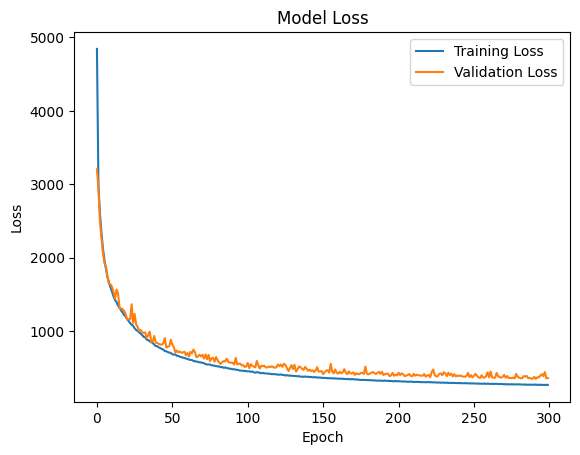

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [16]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
Predicted Solar Energy Ouput: [384.9451904296875, 33.92055130004883, 4.707536697387695, 5.378452301025391, 65.90927124023438, 13.687478065490723, 138.76248168945312, 286.40863037109375, 0.0, 2.747203826904297, 225.8066864013672, 381.01739501953125, 0.79620361328125, 3.3562660217285156, 110.74365234375, 1.1674270629882812, 2.6251296997070312, 512.8216552734375, 488.61676025390625, 363.8173828125]
Actual Solar Energy Output: [404.  29.   0.   9.  64.  11. 187. 254.   2.   4. 202. 408.   1.   0.
  95.   0.   2. 518. 466. 351.]


In [17]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 11.237655592730862
Mean Squared Error (MSE): 371.58680494590516
Root Mean Squared Error (RMSE): 19.27658696309866
Percent Error (PERR): 0.08797299869442184


### Save model

In [18]:
model.save('SolarModel.h5')